In [6]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F


from matplotlib.animation import FuncAnimation



In [15]:
from tsai import *

ModuleNotFoundError: No module named 'tsai'

#Network helper

In [7]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, (8,1), 4, (6,0))

def Downsample(dim):
    return nn.Conv2d(dim, dim, (8,1),4,(6,0))

#Position embeddings

In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

#ResNet/ConvNeXT bloc

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block (Zagoruyko et al., 2016), but Phil Wang decided to also add support for a ConvNeXT block (Liu et al., 2022), as the latter has achieved great success in the image domain. One can choose one or another in the final U-Net architecture.

In [9]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, (13,1), padding = (6,0))
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, (1,1)) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""
    #for images but is it adapted for ts ? 

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, (7,1), padding=(3,0), groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, (3,1), padding=(1,0)),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out,  (3,1), padding=(1,0)),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, (1,1)) if dim != dim_out else nn.Identity()

        self.tmp_dim=dim

    def forward(self, x, time_emb=None):
        #print("x shape in convnextbloc forward",x.shape)
        h = self.ds_conv(x)
        #print("h shape in convnextbloc forward after ds_conv",h.shape)
        

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            #print(condition.shape)
            #print("rearranged b c -> b c 1 1 shape in convnextbloc",rearrange(condition, "b c -> b c 1 1").shape)
            #print("rearranged b c -> b c 1 shape in convnextbloc",rearrange(condition, "b c -> b c 1").shape)
      
            h = h + rearrange(condition, "b c -> b c 1 1")
            #h = h + rearrange(condition, "b c -> b c 1")

       # print("dim:",self.tmp_dim)
       # print("h shape in convnextbloc before net(h) ",h.shape)
        h = self.net(h)
        #print("h shape in convnextbloc after net(h) ",h.shape)

        #print("self.res_conv(x) shape in convnextbloc forward return",self.res_conv(x).shape)
        return h + self.res_conv(x)

#Attention module

In [10]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, (1,1), bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, (1,1))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, (1,1), bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, (1,1)), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

#Group Normalization

In [11]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

#Conditional U-NET

In [12]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim,  (7,1), padding=(3,0)) #HIN = HOUT 

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, (1,1))
        )

    def forward(self, x, time):
        print("=======================UNET--forward=======================")
        #print("x shape before init_conv(x)",x.shape)
        x = self.init_conv(x)
        #print("x shape after init_conv(x)",x.shape)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        #print("t shape ",t.shape)
        h = []

        # downsample
        print("----for loop downs------")
        for block1, block2, attn, downsample in self.downs:
            #print("----------one-down-of-loop-----------------------------")
            #print("ini x shape",x.shape)
            x = block1(x, t)
            #print("block1 x shape",x.shape)
            x = block2(x, t)
            #print("block2 x shape",x.shape)
            x = attn(x)
            #print("attn x shape",x.shape)
            h.append(x)
            x = downsample(x)
            print("downsample x shape",x.shape)
        
        print("----end loop downs------")


        print("----start-bottleneck------")
        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        print("----end---bottleneck------")

        # upsample
        print("----for loop ups------")
        for block1, block2, attn, upsample in self.ups:
            #print("----------one-up-of-loop-----------------------------")
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        print("----end loop ups------")


        print("--------------------UNET--forward--end-------------------------")
        return self.final_conv(x)

#Defining the forward diffusion process

tool functions

Below, we define various schedules for the T timesteps, as well as corresponding variables which we'll need, such as cumulative variances.

In [13]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [14]:
timesteps = 1100

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

#Selim testing

In [12]:

# Univariate classification with sklearn-type API
dsid = 'OliveOil'


x_train, y_train, x_valid, y_valid = get_UCR_data(dsid)   # Download the UCR dataset
#on melange entrainement et validation car pas besoin ici
X_train= np.memmap('X_train', dtype='float32', mode='w+', shape=(60,1,570), order='C')
X_train[:30,:,:] = x_train
X_train[30:,:,:] = x_valid
#pour y jsp 
X_train.shape

(60, 1, 570)

In [13]:
#solution court terme: on travaille avec des séries temporelles de 568 valeur pour avoir des convolution/déconvolutions égales
X_train=X_train[:,:,:568]
v_min, v_max = X_train.min(), X_train.max()
X_train.shape

(60, 1, 568)

In [14]:
X_train[6][0].size

568

In [15]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


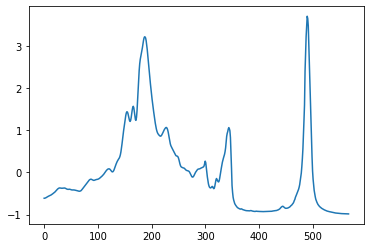

In [16]:
time_serie=X_train[0][0]

plt.plot(time_serie)
plt.show()

In [17]:
def trans_ts(train,min,max):
  return ((train - min)/(max - min)*2 -1)

def restore_ts(train,min,max):
 return min+(train+1)*(max-min)/2




In [18]:
X_train= trans_ts(X_train,v_min,v_max)
print((X_train.min(),X_train.max()))
X_train

(-1.0, 1.0)


array([[[-0.8356644 , -0.8353307 , -0.8336279 , ..., -0.99203247,
         -0.992455  , -0.9928255 ]],

       [[-0.837362  , -0.8366594 , -0.83475673, ..., -0.9924532 ,
         -0.99255395, -0.99257916]],

       [[-0.83592796, -0.83529454, -0.8335506 , ..., -0.9926273 ,
         -0.9927809 , -0.99274945]],

       ...,

       [[-0.8359616 , -0.8349728 , -0.8330419 , ..., -0.9895315 ,
         -0.98967785, -0.98995155]],

       [[-0.834936  , -0.83464074, -0.8330028 , ..., -0.99063665,
         -0.99092436, -0.99099123]],

       [[-0.8402711 , -0.84009016, -0.838854  , ..., -0.98778784,
         -0.9880529 , -0.9881051 ]]], dtype=float32)

In [19]:
X_train_restored= restore_ts(X_train,v_min,v_max)
print((X_train_restored.min(),X_train_restored.max()))
X_train_restored

(-1.0001874, 3.7317405)


array([[[-0.6113753 , -0.6105858 , -0.60655695, ..., -0.9813365 ,
         -0.9823362 , -0.9832128 ]],

       [[-0.61539173, -0.61372936, -0.6092278 , ..., -0.982332  ,
         -0.9825703 , -0.98262995]],

       [[-0.6119989 , -0.6105002 , -0.606374  , ..., -0.9827439 ,
         -0.9831073 , -0.9830329 ]],

       ...,

       [[-0.6120784 , -0.60973895, -0.6051706 , ..., -0.97541934,
         -0.9757655 , -0.97641313]],

       [[-0.609652  , -0.60895336, -0.6050781 , ..., -0.978034  ,
         -0.97871476, -0.97887295]],

       [[-0.62227464, -0.62184644, -0.6189218 , ..., -0.97129387,
         -0.971921  , -0.9720445 ]]], dtype=float32)

In [20]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [21]:
def get_noisy_ts(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into ts
  noisy_ts = x_noisy.squeeze(0).numpy()

  return noisy_ts

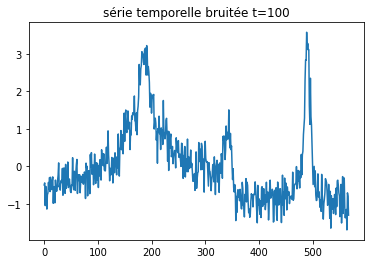

In [22]:
lv=100
t = torch.tensor([lv])
x_start = torch.as_tensor(time_serie).unsqueeze(0)


res_sel=get_noisy_ts(x_start, t)


plt.plot(res_sel)
plt.title("série temporelle bruitée t="+str(lv))
plt.show()

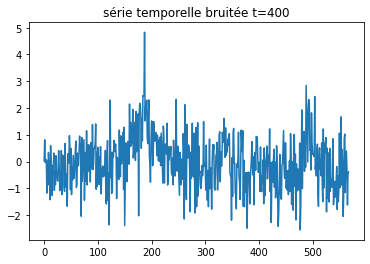

In [23]:
lv=400
t = torch.tensor([lv])
x_start = torch.as_tensor(time_serie).unsqueeze(0)


res_sel=get_noisy_ts(x_start, t)


plt.plot(res_sel)
plt.title("série temporelle bruitée t="+str(lv))
plt.show()

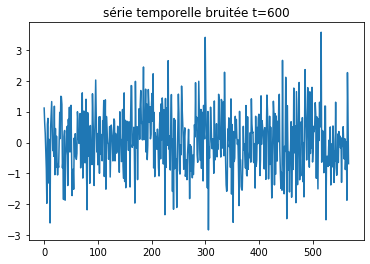

In [24]:
lv=600
t = torch.tensor([lv])
x_start = torch.as_tensor(time_serie).unsqueeze(0)


res_sel=get_noisy_ts(x_start, t)


plt.plot(res_sel)
plt.title("série temporelle bruitée t="+str(lv))
plt.show()

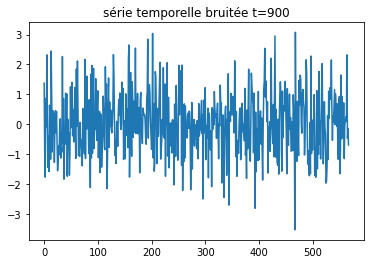

In [25]:
lv=900
t = torch.tensor([900])
x_start = torch.as_tensor(time_serie).unsqueeze(0)


res_sel=get_noisy_ts(x_start, t)


plt.plot(res_sel)
plt.title("série temporelle bruitée t="+str(lv))
plt.show()

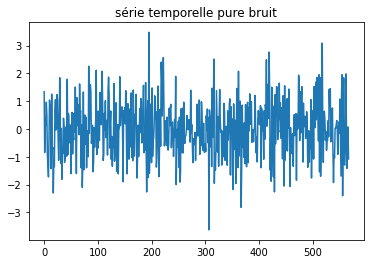

In [26]:
img = torch.randn((568, 1))
plt.plot( torch.as_tensor(img))
plt.title("série temporelle pure bruit")
plt.show()

In [27]:
# function that draws each frame of the animation
def animate(i):
    ax.clear()
    ax.plot(get_noisy_ts(x_start,torch.tensor([i])))


if(0):

  fig, ax = plt.subplots()

  ani = FuncAnimation(fig, animate, frames=100, interval=200, repeat=False)

  ani.save('diffusion.gif')

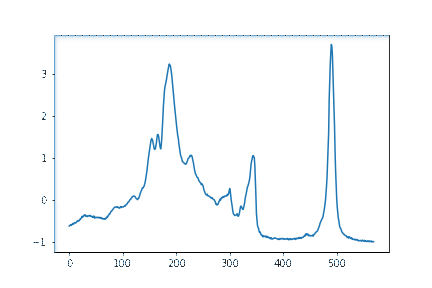

This means that we can now define the loss function given the model.

The denoise_model will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

In [28]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [29]:
image_size =568

channels = 1
batch_size = 12

In [30]:
X_train

array([[[-0.8356644 , -0.8353307 , -0.8336279 , ..., -0.99203247,
         -0.992455  , -0.9928255 ]],

       [[-0.837362  , -0.8366594 , -0.83475673, ..., -0.9924532 ,
         -0.99255395, -0.99257916]],

       [[-0.83592796, -0.83529454, -0.8335506 , ..., -0.9926273 ,
         -0.9927809 , -0.99274945]],

       ...,

       [[-0.8359616 , -0.8349728 , -0.8330419 , ..., -0.9895315 ,
         -0.98967785, -0.98995155]],

       [[-0.834936  , -0.83464074, -0.8330028 , ..., -0.99063665,
         -0.99092436, -0.99099123]],

       [[-0.8402711 , -0.84009016, -0.838854  , ..., -0.98778784,
         -0.9880529 , -0.9881051 ]]], dtype=float32)

In [31]:
dataloader=DataLoader(X_train, batch_size=batch_size, shuffle=True)
dataloader

In [32]:
batch = next(iter(dataloader))
print(batch)

#pas le meme format de batch...normal ? pas normal ? ouf ? pas ouf ? 
#rajouter un index ? 

tensor([[[-0.8403, -0.8398, -0.8383,  ..., -0.9915, -0.9918, -0.9919]],

        [[-0.8378, -0.8373, -0.8357,  ..., -0.9904, -0.9905, -0.9906]],

        [[-0.8403, -0.8397, -0.8381,  ..., -0.9912, -0.9915, -0.9917]],

        ...,

        [[-0.8349, -0.8342, -0.8327,  ..., -0.9898, -0.9900, -0.9899]],

        [[-0.8356, -0.8353, -0.8342,  ..., -0.9921, -0.9924, -0.9923]],

        [[-0.8403, -0.8401, -0.8389,  ..., -0.9878, -0.9881, -0.9881]]])


In [33]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, 1))

In [34]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [35]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchvision.utils import save_image

epochs = 21

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      #batch_size = batch["pixel_values"].shape[0]
      #batch = batch["pixel_values"].to(device)
      batch_size = batch.shape[0]
      batch = batch.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      print("batch.shape 1 in main",batch.shape)
      batch=rearrange(batch, "nb ch val-> nb ch val 1")
      print("batch.shape 2 in main",batch.shape)

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("///////Epoch ",epoch," step ",step," Loss:", loss.item(),"/////////")

      loss.backward()
      optimizer.step()

      # save generated images
      #if step != 0 and step % save_and_sample_every == 0:
      #  milestone = step // save_and_sample_every
      #  batches = num_to_groups(4, batch_size)
      #  all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #  all_images = torch.cat(all_images_list, dim=0)
      #  all_images = (all_images + 1) * 0.5
      #  save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

batch.shape 1 in main torch.Size([12, 1, 568])
batch.shape 2 in main torch.Size([12, 1, 568, 1])
=======================UNET--forward=======================
----for loop downs------
downsample x shape torch.Size([12, 568, 144, 1])
downsample x shape torch.Size([12, 1136, 38, 1])
downsample x shape torch.Size([12, 2272, 38, 1])
----end loop downs------
----start-bottleneck------
----end---bottleneck------
----for loop ups------
----end loop ups------
--------------------UNET--forward--end-------------------------
///////Epoch  0  step  0  Loss: 0.4942178428173065 /////////
batch.shape 1 in main torch.Size([12, 1, 568])
batch.shape 2 in main torch.Size([12, 1, 568, 1])
=======================UNET--forward=======================
----for loop downs------
downsample x shape torch.Size([12, 568, 144, 1])
downsample x shape torch.Size([12, 1136, 38, 1])
downsample x shape torch.Size([12, 2272, 38, 1])
----end loop downs------
----start-bottleneck------
----end---bottleneck------
----for loop 

In [ ]:
samples = sample(model, image_size=image_size, batch_size=5, channels=channels)

In [ ]:
samples[0].shape

In [ ]:
imgbruit = torch.randn((568, 1))
plt.plot( torch.as_tensor(imgbruit))
plt.title("série temporelle pure bruit")
plt.show()

In [ ]:
plt.plot(restore_ts(samples[-1][0],v_min,v_max).squeeze(0))
plt.title("série générée 1")
plt.show()
plt.plot(restore_ts(samples[-1][1],v_min,v_max).squeeze(0))
plt.title("série générée 2")
plt.show()
plt.plot(restore_ts(samples[-1][2],v_min,v_max).squeeze(0))
plt.title("série générée 3")
plt.show()
plt.plot(restore_ts(samples[-1][3],v_min,v_max).squeeze(0))
plt.title("série générée 4")
plt.show()
plt.plot(restore_ts(samples[-1][4],v_min,v_max).squeeze(0))
plt.title("série générée 5")
plt.show()

In [ ]:
plt.plot((restore_ts(samples[-1][1],v_min,v_max)-restore_ts(samples[-1][4],v_min,v_max)).squeeze(0))
plt.title("différence 2 séries")
plt.show()